<a href="https://colab.research.google.com/github/BogatiyPapa1/Video-bez/blob/main/%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%86%D0%B8%D1%8F_%D0%B2%D0%B8%D0%B4%D0%B5%D0%BE_%D0%BE%D0%BD%D0%BB%D0%B0%D0%B9%D0%BD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Вы можете использовать бесплатный графический процессор T4 для запуска этого ноутбука с моделью Q4 GGUF по умолчанию.
- **Чтобы использовать lora, вставьте ссылку для скачивания huggingface в текстовое поле `lora_hf_download_url` или установите флажок `download_lora_from_civitai` и введите ссылку для скачивания LoRA и ваш токен civitai перед запуском кода в `Prepare Environment`. Не забудьте описать основной предмет изображения и включить в подсказку триггерные слова для LoRA. Вы можете получить LoRA из этого репозитория huggingface: https://huggingface.co/collections/Remade-AI/wan21-14b-480p-i2v-loras-67d0e26f08092436b585919b и из civitai: https://civitai.com/models. В civitai установите фильтры «Wan Video» и «LoRA», чтобы увидеть Wan LoRA.**
- Создание видео из этого изображения flux (https://comfyanonymous.github.io/ComfyUI_examples/flux/) с настройками (480x480, 20 шагов, 65 кадров) с использованием модели Q4 GGUF и бесплатного GPU T4 заняло около 33 минут без Teacache, т. е. с `rel_l1_threshless`, установленным на ноль в настройках Teacache, и менее 18 минут с `rel_l1_threshless`, установленным на 0,275, с небольшой потерей качества. Увеличьте значение `rel_l1_threshless` для более быстрого генерации с ущербом для качества.
- Видео генерируются со скоростью 16 кадров в секунду. Вы можете использовать блокнот `Frame Interpolation` в этом репозитории github (https://github.com/Isi-dev/Google-Colab_Notebooks), чтобы увеличить эту скорость.

In [ ]:
# @title Prepare Environment
# !pip install --upgrade --quiet torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install torch==2.6.0 torchvision==0.21.0
%cd /content
from IPython.display import clear_output
!pip install -q torchsde einops diffusers accelerate xformers==0.0.29.post2 triton sageattention
!pip install av
clear_output()
!git clone https://github.com/Isi-dev/ComfyUI
clear_output()
%cd /content/ComfyUI/custom_nodes
!git clone https://github.com/Isi-dev/ComfyUI_GGUF.git
clear_output()
!git clone https://github.com/Isi-dev/ComfyUI_KJNodes.git
clear_output()
%cd /content/ComfyUI/custom_nodes/ComfyUI_GGUF
!pip install -r requirements.txt
clear_output()
%cd /content/ComfyUI/custom_nodes/ComfyUI_KJNodes
!pip install -r requirements.txt
clear_output()
%cd /content/ComfyUI
!apt -y install -qq aria2 ffmpeg
clear_output()

useQ6 = False # @param {"type":"boolean"}

lora = "flyingEffect.safetensors"

lora_hf_download_url = "https://huggingface.co/Kijai/WanVideo_comfy/resolve/main/Wan21_CausVid_14B_T2V_lora_rank32.safetensors"# @param {"type":"string"}
download_lora_from_civitai = False # @param {"type":"boolean"}
lora_civitai_download_url = "https://civitai.com/api/download/models/1604714?type=Model&format=SafeTensor"# @param {"type":"string"}
civitai_token = "93f02f46df963cf781ed199948da6700"# @param {"type":"string"}

def download_with_aria2c(link, folder="/content/ComfyUI/models/loras"):
    import os

    filename = link.split("/")[-1]
    command = f"aria2c --console-log-level=error -c -x 16 -s 16 -k 1M {link} -d {folder} -o {filename}"

    print("Executing download command:")
    print(command)

    os.makedirs(folder, exist_ok=True)
    get_ipython().system(command)

    return filename



def download_civitai_model(civitai_link, civitai_token, folder="/content/ComfyUI/models/loras"):
    import os
    import time

    os.makedirs(folder, exist_ok=True)

    try:
        model_id = civitai_link.split("/models/")[1].split("?")[0]
    except IndexError:
        raise ValueError("Invalid Civitai URL format. Please use a link like: https://civitai.com/api/download/models/1523247?...")

    civitai_url = f"https://civitai.com/api/download/models/{model_id}?type=Model&format=SafeTensor"
    if civitai_token:
        civitai_url += f"&token={civitai_token}"

    timestamp = time.strftime("%Y%m%d_%H%M%S")
    filename = f"model_{timestamp}.safetensors"

    full_path = os.path.join(folder, filename)

    download_command = f"wget --max-redirect=10 --show-progress \"{civitai_url}\" -O \"{full_path}\""
    print("Downloading from Civitai...")

    os.system(download_command)

    local_path = os.path.join(folder, filename)
    if os.path.exists(local_path) and os.path.getsize(local_path) > 0:
        print(f"LoRA downloaded successfully: {local_path}")
    else:
        print(f"❌ LoRA download failed or file is empty: {local_path}")

    return filename



import torch
import numpy as np
from PIL import Image
import gc
import sys
import random
import os
import imageio
import subprocess
from google.colab import files
from IPython.display import display, HTML, Image as IPImage
sys.path.insert(0, '/content/ComfyUI')

from comfy import model_management

from nodes import (
    CheckpointLoaderSimple,
    CLIPLoader,
    CLIPTextEncode,
    VAEDecode,
    VAELoader,
    KSampler,
    UNETLoader,
    LoadImage,
    CLIPVisionLoader,
    CLIPVisionEncode,
    LoraLoaderModelOnly
)

from custom_nodes.ComfyUI_GGUF.nodes import UnetLoaderGGUF
from custom_nodes.ComfyUI_KJNodes.nodes.model_optimization_nodes import (
    WanVideoTeaCacheKJ,
    PathchSageAttentionKJ
)

from comfy_extras.nodes_model_advanced import ModelSamplingSD3
from comfy_extras.nodes_images import SaveAnimatedWEBP
from comfy_extras.nodes_video import SaveWEBM
from comfy_extras.nodes_wan import WanImageToVideo

if download_lora_from_civitai:
    lora = download_civitai_model(lora_civitai_download_url, civitai_token)
else:
    lora = download_with_aria2c(lora_hf_download_url)


if useQ6:
    !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/city96/Wan2.1-I2V-14B-480P-gguf/resolve/main/wan2.1-i2v-14b-480p-Q6_K.gguf -d /content/ComfyUI/models/unet -o wan2.1-i2v-14b-480p-Q6_K.gguf
else:
    !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/city96/Wan2.1-I2V-14B-480P-gguf/resolve/main/wan2.1-i2v-14b-480p-Q4_0.gguf -d /content/ComfyUI/models/unet -o wan2.1-i2v-14b-480p-Q4_0.gguf
clear_output()
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/Comfy-Org/Wan_2.1_ComfyUI_repackaged/resolve/main/split_files/text_encoders/umt5_xxl_fp8_e4m3fn_scaled.safetensors -d /content/ComfyUI/models/text_encoders -o umt5_xxl_fp8_e4m3fn_scaled.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/Comfy-Org/Wan_2.1_ComfyUI_repackaged/resolve/main/split_files/vae/wan_2.1_vae.safetensors -d /content/ComfyUI/models/vae -o wan_2.1_vae.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/Comfy-Org/Wan_2.1_ComfyUI_repackaged/resolve/main/split_files/clip_vision/clip_vision_h.safetensors -d /content/ComfyUI/models/clip_vision -o clip_vision_h.safetensors
clear_output()
# Initialize nodes
unet_loader = UnetLoaderGGUF()
pathch_sage_attention = PathchSageAttentionKJ()
teacache = WanVideoTeaCacheKJ()
model_sampling = ModelSamplingSD3()
clip_loader = CLIPLoader()
clip_encode_positive = CLIPTextEncode()
clip_encode_negative = CLIPTextEncode()
vae_loader = VAELoader()
clip_vision_loader = CLIPVisionLoader()
clip_vision_encode = CLIPVisionEncode()
load_image = LoadImage()
wan_image_to_video = WanImageToVideo()
ksampler = KSampler()
vae_decode = VAEDecode()
save_webp = SaveAnimatedWEBP()
save_webm = SaveWEBM()
load_lora = LoraLoaderModelOnly()

def clear_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
    for obj in list(globals().values()):
        if torch.is_tensor(obj) or (hasattr(obj, "data") and torch.is_tensor(obj.data)):
            del obj
    gc.collect()

def save_as_mp4(images, filename_prefix, fps, output_dir="/content/ComfyUI/output"):
    os.makedirs(output_dir, exist_ok=True)
    output_path = f"{output_dir}/{filename_prefix}.mp4"

    frames = [(img.cpu().numpy() * 255).astype(np.uint8) for img in images]

    with imageio.get_writer(output_path, fps=fps) as writer:
        for frame in frames:
            writer.append_data(frame)

    return output_path

def save_as_webp(images, filename_prefix, fps, quality=90, lossless=False, method=4, output_dir="/content/ComfyUI/output"):
    """Save images as animated WEBP using imageio."""
    os.makedirs(output_dir, exist_ok=True)
    output_path = f"{output_dir}/{filename_prefix}.webp"


    frames = [(img.cpu().numpy() * 255).astype(np.uint8) for img in images]


    kwargs = {
        'fps': int(fps),
        'quality': int(quality),
        'lossless': bool(lossless),
        'method': int(method)
    }

    with imageio.get_writer(
        output_path,
        format='WEBP',
        mode='I',
        **kwargs
    ) as writer:
        for frame in frames:
            writer.append_data(frame)

    return output_path

def save_as_webm(images, filename_prefix, fps, codec="vp9", quality=32, output_dir="/content/ComfyUI/output"):
    """Save images as WEBM using imageio."""
    os.makedirs(output_dir, exist_ok=True)
    output_path = f"{output_dir}/{filename_prefix}.webm"


    frames = [(img.cpu().numpy() * 255).astype(np.uint8) for img in images]


    kwargs = {
        'fps': int(fps),
        'quality': int(quality),
        'codec': str(codec),
        'output_params': ['-crf', str(int(quality))]
    }

    with imageio.get_writer(
        output_path,
        format='FFMPEG',
        mode='I',
        **kwargs
    ) as writer:
        for frame in frames:
            writer.append_data(frame)

    return output_path

def save_as_image(image, filename_prefix, output_dir="/content/ComfyUI/output"):
    """Save single frame as PNG image."""
    os.makedirs(output_dir, exist_ok=True)
    output_path = f"{output_dir}/{filename_prefix}.png"

    frame = (image.cpu().numpy() * 255).astype(np.uint8)

    Image.fromarray(frame).save(output_path)

    return output_path


def upload_image():
    """Handle image upload in Colab and store in /content/ComfyUI/input/"""
    from google.colab import files
    import os
    import shutil

    os.makedirs('/content/ComfyUI/input', exist_ok=True)

    uploaded = files.upload()

    # Move each uploaded file to ComfyUI input directory
    for filename in uploaded.keys():
        src_path = f'/content/ComfyUI/{filename}'
        dest_path = f'/content/ComfyUI/input/{filename}'

        shutil.move(src_path, dest_path)
        print(f"Image saved to: {dest_path}")
        return dest_path

    return None

def generate_video(
    image_path: str = None,
    LoRA_Strength: float = 1.00,
    rel_l1_thresh: float = 0.275,
    start_percent: float = 0.1,
    end_percent: float = 1.0,
    positive_prompt: str = "a cute anime girl with massive fennec ears and a big fluffy tail wearing a maid outfit turning around",
    negative_prompt: str = "色调艳丽，过曝，静态，细节模糊不清，字幕，风格，作品，画作，画面，静止，整体发灰，最差质量，低质量，JPEG压缩残留，丑陋的，残缺的，多余的手指，画得不好的手部，画得不好的脸部，畸形的，毁容的，形态畸形的肢体，手指融合，静止不动的画面，杂乱的背景，三条腿，背景人很多，倒着走",
    width: int = 832,
    height: int = 480,
    seed: int = 82628696717253,
    steps: int = 20,
    cfg_scale: float = 1.0,
    sampler_name: str = "uni_pc",
    scheduler: str = "simple",
    frames: int = 33,
    fps: int = 16,
    output_format: str = "mp4",
    overwrite: bool = False,
    use_lora: bool = True,
    use_sage_attention: bool = True,
    enable_flow_shift: bool = True,
    shift: float = 8.0
):

    with torch.inference_mode():
        print("Loading Text_Encoder...")
        clip = clip_loader.load_clip("umt5_xxl_fp8_e4m3fn_scaled.safetensors", "wan", "default")[0]

        positive = clip_encode_positive.encode(clip, positive_prompt)[0]
        negative = clip_encode_negative.encode(clip, negative_prompt)[0]

        del clip
        torch.cuda.empty_cache()
        gc.collect()

        if image_path is None:
            print("Please upload an image file:")
            image_path = upload_image()
        if image_path is None:
            print("No image uploaded!")
        loaded_image = load_image.load_image(image_path)[0]
        clip_vision = clip_vision_loader.load_clip("clip_vision_h.safetensors")[0]
        clip_vision_output = clip_vision_encode.encode(clip_vision, loaded_image, "none")[0]

        del clip_vision
        torch.cuda.empty_cache()
        gc.collect()

        print("Loading VAE...")
        vae = vae_loader.load_vae("wan_2.1_vae.safetensors")[0]

        positive_out, negative_out, latent = wan_image_to_video.encode(
            positive, negative, vae, width, height, frames, 1, loaded_image, clip_vision_output
        )

        print("Loading Unet Model...")
        if useQ6:
            model = unet_loader.load_unet("wan2.1-i2v-14b-480p-Q6_K.gguf")[0]
        else:
            model = unet_loader.load_unet("wan2.1-i2v-14b-480p-Q4_0.gguf")[0]

        if enable_flow_shift:
            model = model_sampling.patch(model, shift)[0]

        if use_lora:
            print("Loading Lora...")
            model = load_lora.load_lora_model_only(model, lora, LoRA_Strength)[0]

        if use_sage_attention:
            model = pathch_sage_attention.patch(model, "auto")[0]

        if rel_l1_thresh > 0:
            print("Setting Teacache...")
            model = teacache.patch_teacache(model, rel_l1_thresh, start_percent, end_percent, "main_device", "i2v_480")[0]

        print("Generating video...")
        sampled = ksampler.sample(
            model=model,
            seed=seed,
            steps=steps,
            cfg=cfg_scale,
            sampler_name=sampler_name,
            scheduler=scheduler,
            positive=positive_out,
            negative=negative_out,
            latent_image=latent
        )[0]

        del model
        torch.cuda.empty_cache()
        gc.collect()

        try:
            print("Decoding latents...")
            decoded = vae_decode.decode(vae, sampled)[0]

            del vae
            torch.cuda.empty_cache()
            gc.collect()

            output_path = ""
            import datetime
            base_name = "ComfyUI"
            if not overwrite:
                timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
                base_name += f"_{timestamp}"
            if frames == 1:
                print("Single frame detected - saving as PNG image...")
                output_path = save_as_image(decoded[0], "ComfyUI")
                # print(f"Image saved as PNG: {output_path}")

                display(IPImage(filename=output_path))
            else:
                if output_format.lower() == "webm":
                    print("Saving as WEBM...")
                    output_path = save_as_webm(
                        decoded,
                        base_name,
                        fps=fps,
                        codec="vp9",
                        quality=10
                    )
                elif output_format.lower() == "mp4":
                    print("Saving as MP4...")
                    output_path = save_as_mp4(decoded, base_name, fps)

                    # output_path = save_as_mp4(decoded, "ComfyUI", fps)
                else:
                    raise ValueError(f"Unsupported output format: {output_format}")

                # print(f"Video saved as {output_format.upper()}: {output_path}")

                display_video(output_path)

        except Exception as e:
            print(f"Error during decoding/saving: {str(e)}")
            raise
        finally:
            clear_memory()

def display_video(video_path):
    from IPython.display import HTML
    from base64 import b64encode

    video_data = open(video_path,'rb').read()

    # Determine MIME type based on file extension
    if video_path.lower().endswith('.mp4'):
        mime_type = "video/mp4"
    elif video_path.lower().endswith('.webm'):
        mime_type = "video/webm"
    elif video_path.lower().endswith('.webp'):
        mime_type = "image/webp"
    else:
        mime_type = "video/mp4"  # default

    data_url = f"data:{mime_type};base64," + b64encode(video_data).decode()

    display(HTML(f"""
    <video width=512 controls autoplay loop>
        <source src="{data_url}" type="{mime_type}">
    </video>
    """))

print("✅ Environment Setup Complete!")

✅ Environment Setup Complete!



*   В `positive_prompt` пишем то, что хотите сгенерировать

*   `negative_prompt` не меняем

* `width` и `height` ставим **480**. Это высота и ширина нашего видео

* Дальше ничего не меняем в настройках видео

* Значение `frames` это длинна нашего видео в кадрах. По умолчанию стоит 68 кадров. При 16 кадрах в секунду длина видео будет 4,25 секунды. **Ставить больше 70 не рекомендуется**

* Значение `fps` это наше значение кадров в секунду. **Не рекомендуется ставить больше 16, так как может возникать ошибка нехватки памяти.**




После запуска этого блока у вас появиться такое окно: 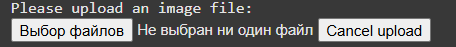
Тут нажимаем `Выбор файлов` и выбираем нашу фотографию.

# **Всё! Дальше будет происходить генерация видео. По окончании генерации вам будет показано ваше видео. Так-же вы сможете его скачать.**

Параметр `Teacache Settings`
         `rel_l1_thresh:`   лучше оставить на значение `0`. **Но если вам неважно качество генерации, а важна скорость - можете ставить в значении от `0.050` до `0.150`**

При таких настройках генерация видео займёт у вас от 20 до 30 минут.

# **Удачного использования!**


Сделано на заказ. Если у вас возникли проблемы (telegram): @sleepyyy3

In [ ]:
# @title Generate Video

# @markdown ---
# @markdown ### Video Settings
positive_prompt = "" # @param {"type":"string"}
negative_prompt = "色调艳丽，过曝，静态，细节模糊不清，字幕，风格，作品，画作，画面，静止，整体发灰，最差质量，低质量，JPEG压缩残留，丑陋的，残缺的，多余的手指，画得不好的手部，画得不好的脸部，畸形的，毁容的，形态畸形的肢体，手指融合，静止不动的画面，杂乱的背景，三条腿，背景人很多，倒着走" # @param {"type":"string"}
width = 480 # @param {"type":"number"}
height = 480 # @param {"type":"number"}
seed = 0 # @param {"type":"integer"}
steps = 20 # @param {"type":"integer", "min":1, "max":100}
cfg_scale = 3 # @param {"type":"number", "min":1, "max":20}
sampler_name = "uni_pc" # @param ["uni_pc", "euler", "dpmpp_2m", "ddim", "lms"]
scheduler = "simple" # @param ["simple", "normal", "karras", "exponential"]
frames = 68 # @param {"type":"integer", "min":1, "max":120}
fps = 16 # @param {"type":"integer", "min":1, "max":60}
output_format = "mp4" # @param ["mp4", "webm"]
overwrite_previous_video = False # @param {type:"boolean"}
# @markdown ---
# @markdown ### Model Configuration
# use_sage_attention = False # @param {type:"boolean"}
use_sage_attention = False
use_flow_shift = True # @param {type:"boolean"}
flow_shift = 3.37 # @param {"type":"slider","min":0.0,"max":100.0,"step":0.01}
# @markdown ---
# @markdown ### LoRA Configuration
use_lora = False # @param {type:"boolean"}
LoRA_Strength = 1.0 # @param {"type":"slider","min":-100,"max":100,"step":0.01}
# @markdown ---
# @markdown ### Teacache Settings
rel_l1_thresh = 0 # @param {"type":"slider","min":0.0,"max":10,"step":0.001}
start_percent = 0.84 # @param {"type":"slider","min":0.0,"max":1.0,"step":0.01}
end_percent = 1.0 # @param {"type":"slider","min":0.0,"max":1.0,"step":0.01}

import random
seed = seed if seed != 0 else random.randint(0, 2**32 - 1)
print(f"Using seed: {seed}")

# with torch.inference_mode():
generate_video(
    image_path=None,
    LoRA_Strength=LoRA_Strength,
    rel_l1_thresh=rel_l1_thresh,
    start_percent=start_percent,
    end_percent = end_percent,
    positive_prompt=positive_prompt,
    negative_prompt=negative_prompt,
    width=width,
    height=height,
    seed=seed,
    steps=steps,
    cfg_scale=cfg_scale,
    sampler_name=sampler_name,
    scheduler=scheduler,
    frames=frames,
    fps=fps,
    output_format=output_format,
    overwrite=overwrite_previous_video,
    use_lora = use_lora,
    use_sage_attention = use_sage_attention,
    enable_flow_shift = use_flow_shift,
    shift = flow_shift
)
clear_memory()

Using seed: 343269067
Loading Text_Encoder...
Please upload an image file:


Saving IMG_20250623_000034_748.jpg to IMG_20250623_000034_748.jpg
Image saved to: /content/ComfyUI/input/IMG_20250623_000034_748.jpg
Loading VAE...
Loading Unet Model...
gguf qtypes: F32 (823), Q4_0 (440), Q4_1 (40)
Generating video...


  0%|          | 0/20 [00:00<?, ?it/s]